In [1]:
# ! pip install dask leidenalg

In [2]:
import sys

path_src = '../src'
sys.path.append(path_src)
import importlib
import SpatialAnalysis as SpAn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
import os
path_src = '../../mosna_benchmark/mosna/'
sys.path.append(path_src)
import mosna2 as mosna


Script loaded!
imported


2024-07-29 17:06:19.972460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 17:06:20.108545: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 17:06:20.595076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/cv2/../../lib64:
202

Script loaded!


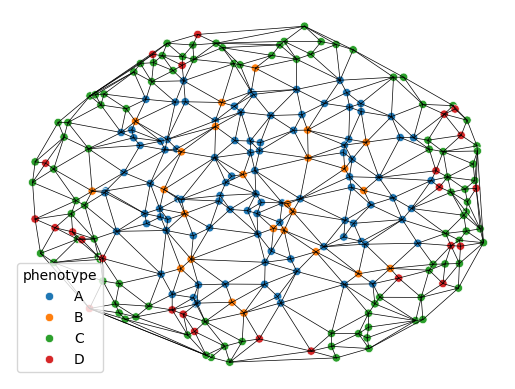

N# edges: 721


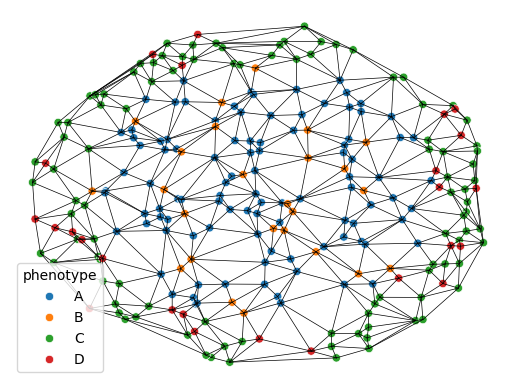

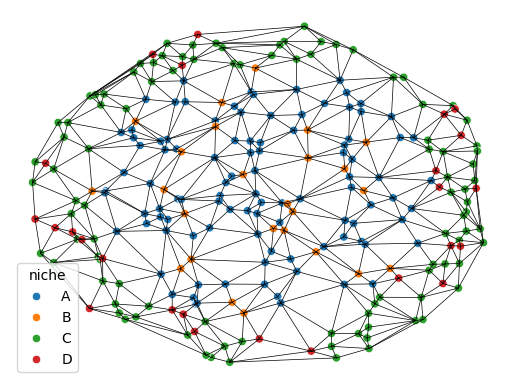

,x,y,phenotype,niche,A,B,C,D,patient,A,B,C,D
80,9.117909,9.24924,A,A,1,0,0,0,1,1,0,0,0


In [3]:
type = 'boundries'
thr = 2
importlib.reload(SpAn)
coords = pd.read_csv('../data/niche_simulations/'+type+'.csv',sep=',',index_col=0)
points = coords[['x','y']]
types = coords['phenotype']
edges = SpAn.delaunay_edges(points)
SpAn.plot_network(points, edges, types = types, linewidth = .5)
edges = SpAn.trim_edges_by_distance(points, edges, thr )
print(f'N# edges: {len(edges)}')
SpAn.plot_network(points, edges, types = types, linewidth = .5)


coords['niche'] = coords['phenotype'].str[-1:]
SpAn.plot_network(points, edges, types = coords['niche'], linewidth = .5)
dum = pd.get_dummies(coords['phenotype']).astype('int')
nodes = pd.concat([coords, dum],axis=1)
nodes['patient'] = '1'

dum_niches = pd.get_dummies(nodes['niche']).astype('int')
dum_niches.sample()
NichDum = pd.get_dummies(nodes['niche']).astype('int')
niche_cols = NichDum.columns
nodes = pd.concat( [nodes,NichDum] , axis=1)

out_path = '../data/simulation_coordiantes/mosna/'+type+'/net_dir/'
out_dir = out_path + 'nodes_patient-patient.csv'
os.makedirs(out_path, exist_ok=True)
nodes.to_csv(out_dir, index=False)

nodes.sample()

In [4]:
nodes.shape

(250, 13)

# Mosna

In [5]:
pd.DataFrame(edges).to_csv(out_path + 'edges_patient-patient.csv', index=False)

imported
Loading clusterer object and cluster labels
There are 3 clusters


<Figure size 3000x3000 with 0 Axes>

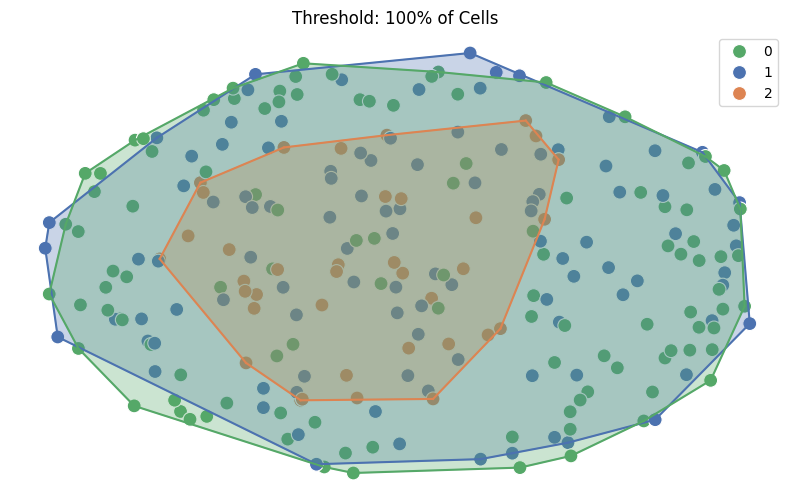

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [6]:
attributes_col = nodes.columns
marker_col = dum.columns

data_info = ['patient']
importlib.reload(mosna)
var_aggreg = mosna.compute_spatial_omic_features_single_network(
    method = 'NAS',
    net_dir = out_path,  
    data_info = data_info,
    extension = 'csv',
    read_fct = pd.read_csv,
    attributes_col=attributes_col, 
    use_attributes=marker_col, # use all attributes 
    make_onehot=False, 
    stat_funcs = 'default', 
    stat_names = 'default', 
    id_level_1='patient',
    save_intermediate_results=False, 
    dir_save_interm=None,
    add_sample_info = False,
    verbose=1,
    )

plt.gcf().set_size_inches(30, 30)

cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 30, 
    'metric': 'euclidean', #'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 30, 
    'resolution_parameter': 0.001,
}

sof_dir = out_path

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, sof_dir, **cluster_params)

import pathlib
sof_dir = pathlib.Path(sof_dir)

var = 'MOSNA'

nodes[var] = cluster_labels

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.3)


# UTAG

/tmp/ipykernel_670252/4086629326.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['roi'] = 'ROI1'
/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 250 × 4
    obs: 'x', 'y', 'roi'
    obsm: 'spatial'

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

Overwriding provided number of PCA dimensions to match number of features: 3


/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 1/1 [00:00<00:00, 32.61it/s]


Applying Leiden Clustering at Resolution: 0.05...


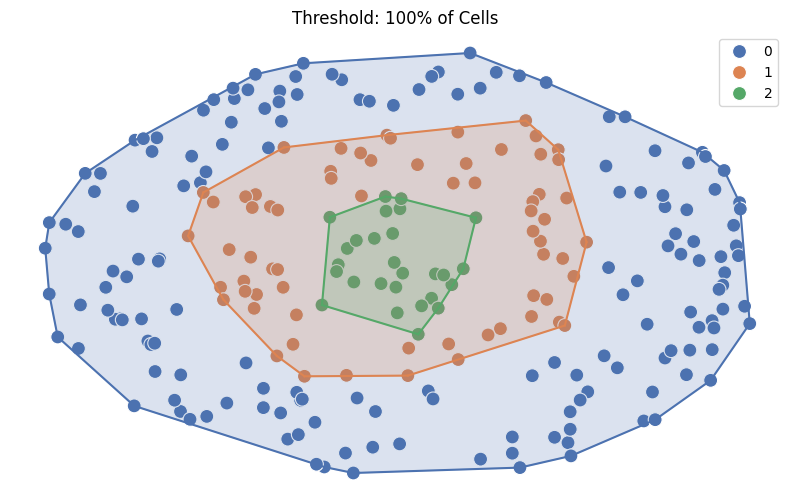

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [7]:
from utag import utag
import scanpy as sc
import squidpy as sq
import anndata
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData
import anndata as ad

X = pd.get_dummies(coords['phenotype']).astype(np.float64)

obs = coords[['x', 'y']]
obs['roi'] = 'ROI1'
# Create 'var' dataframe with the one-hot encoded types columns
var = pd.DataFrame(index=X.columns)

# Create AnnData object
minimal_adata = ad.AnnData(X=X.values, obs=obs, var=var)
minimal_adata.obsm['spatial'] = coords[['x', 'y']].values

single_slide = minimal_adata.copy()
display(single_slide)
# Run UTAG on provided data
utag_single_results = utag(
    single_slide,
    slide_key="roi",
    max_dist=2,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.05]
)

var= 'UTAG'
nodes[var] = utag_single_results.obs['UTAG Label_leiden_0.05'].values

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.2)


# Cellcharter

In [8]:
import anndata as ad
import cellcharter as cc
nodes.sample()

,x,y,phenotype,niche,A,B,C,D,patient,A,B,C,D,MOSNA,UTAG
11,12.369244,11.333786,A,A,1,0,0,0,1,1,0,0,0,1,0


/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


  0%|          | 0/4 [00:00<?, ?it/s]

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

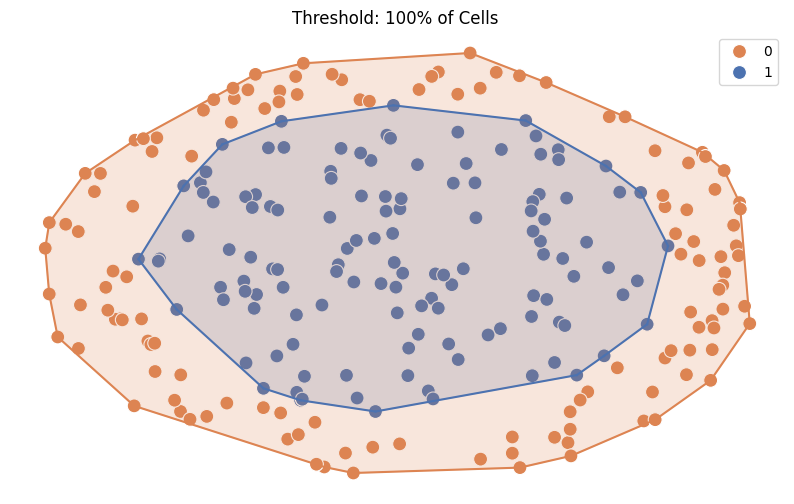

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [9]:
adata = ad.AnnData(X=dum)
adata.obs['niche'] = nodes['niche'].values
adata.obs['cell_type'] = nodes['phenotype'].values
adata.obs['patient'] = nodes['patient'].values
adata.uns['spatial'] = {'coordinates': nodes[['x', 'y']].values.tolist()}
adata.obsm['spatial'] = nodes[['x', 'y']].values
adata

sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True)

cc.gr.remove_long_links(adata)

cc.gr.aggregate_neighbors(adata, n_layers=3)
gmm = cc.tl.Cluster(
    n_clusters=2, 
    trainer_params=dict(accelerator='gpu', devices=1)
)
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')


var = 'CellCharter'

nodes[var] = adata.obs['spatial_cluster'].values

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.2)

# Stagate

# BayesSpace

#### Check file ```rscript/BayesSpace.R``` for details about running BayesSpace 

In [10]:
nodes.shape

(250, 16)

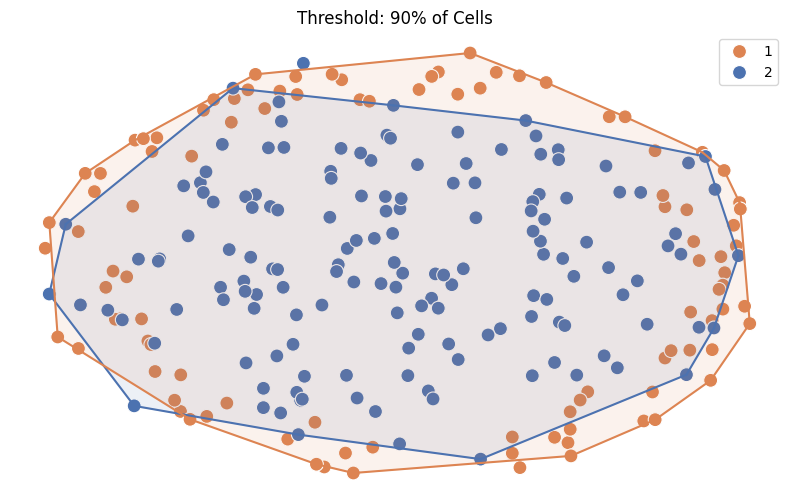

<Axes: title={'center': 'Threshold: 90% of Cells '}>

In [11]:
BayesSpace = pd.read_csv('../data/simulation_coordiantes/BayesSpace/boundries.csv', index_col=0)
var = 'BayesSpace'
nodes[var] = BayesSpace['spatial.cluster'].values
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)


# SquidPy + scanpy

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


  0%|          | 0/1000 [00:00<?, ?/s]

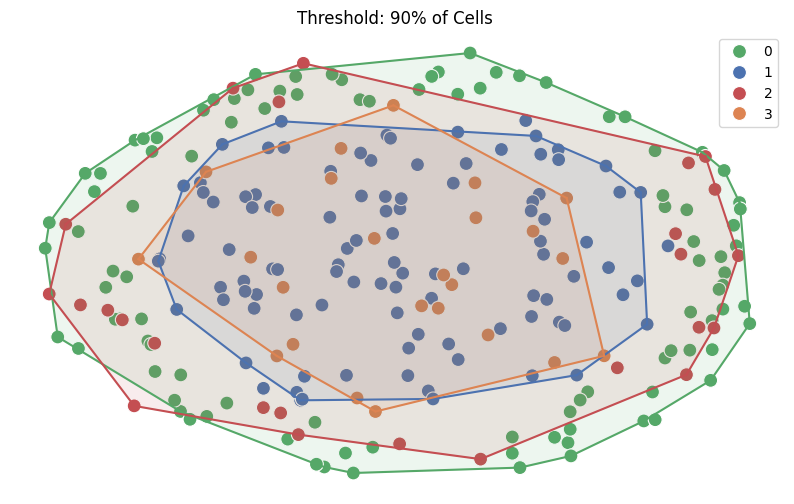

<Axes: title={'center': 'Threshold: 90% of Cells '}>

In [12]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np

# Assuming `data` is your dataset containing 'coordinates' and 'cell_type'
# Create an AnnData object

adata = ad.AnnData(X=dum)  # Random data, replace with your actual gene expression matrix

adata.obs['cell_type'] = pd.Categorical(nodes['phenotype'])  # Random cell types, replace with actual
adata.obsm['spatial'] = nodes[['x','y']].values  # Random coordinates, replace with actual

# Calculate neighborhood enrichment
sq.gr.spatial_neighbors(adata, coord_type="generic")  # Adjust parameters as needed
sq.gr.nhood_enrichment(adata, cluster_key='cell_type')

# Plot neighborhood enrichment
# sq.pl.nhood_enrichment(adata, cluster_key='cell_type')

# Additional visualization to explore the spatial distribution
# sc.pl.embedding(adata, basis='spatial', color='cell_type', s=100, palette='rainbow')


sc.pp.neighbors(adata, 20)
# Perform clustering
sc.tl.leiden(adata,  resolution=.01)

# Add clustering results to the data
adata.obs['clusters'] = adata.obs['leiden']


var = 'SquidPy'
nodes[var] =  adata.obs['leiden'].values
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)

# StLearn

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


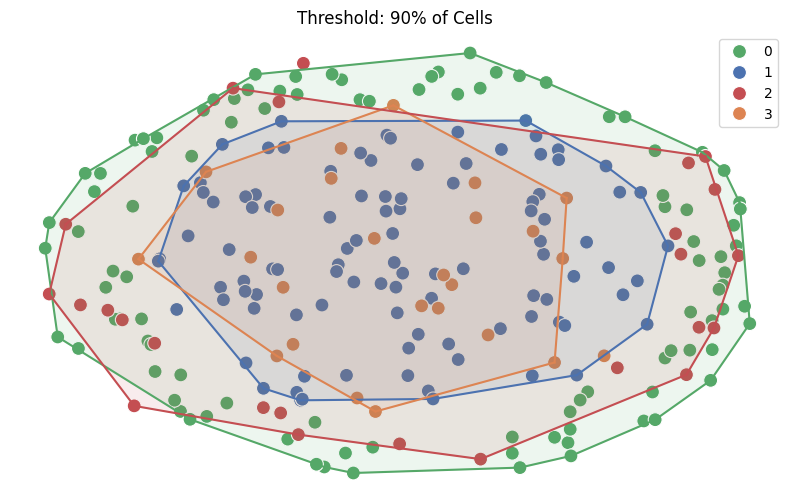

<Axes: title={'center': 'Threshold: 90% of Cells '}>

In [13]:
import stlearn as st
import scanpy as sc

coordinates = nodes[['x','y']]

# Create an AnnData object
adata = sc.AnnData(X = dum )
adata.obsm['spatial'] = coordinates.values

# Add cell types as metadata
adata.obs['cell_type'] = pd.Categorical(nodes['phenotype'].values)

# Normalize and scale the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# adata = adata[:, adata.var.highly_variable]

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbors and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.002)

# Visualize the clusters
# sc.pl.umap(adata, color=['leiden', 'cell_type'])


var = 'StLearn'
nodes[var] =  adata.obs['leiden'].values
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)

# imcRtools

#### Check file ```rscript/imcRtools.R``` for more details 

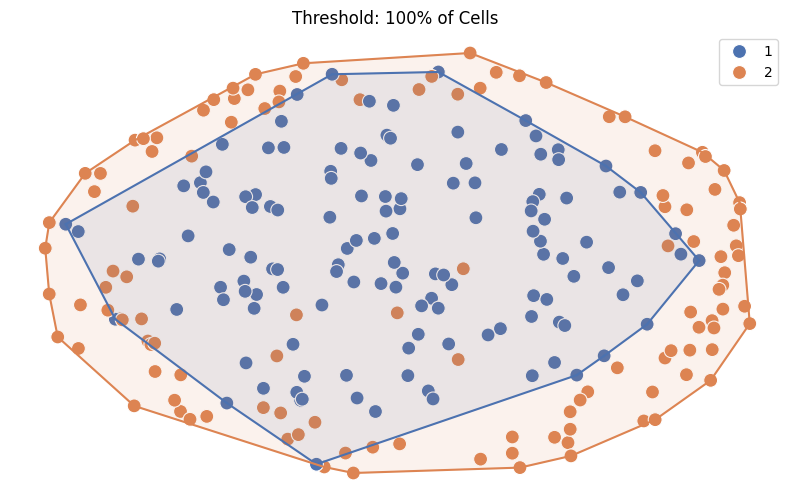

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [14]:
aN = pd.read_csv('../data/simulation_coordiantes/imcRtools/boundries.csv')
imcRtoolsAN = pd.concat([nodes,aN], axis=1)
imcRtoolsAN.sample()


var = 'imcRtools'
nodes[var] = imcRtoolsAN['clustered_neighbors'].values
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.1)

# Compare

# Adding an annotation of each cell type an it neighboor

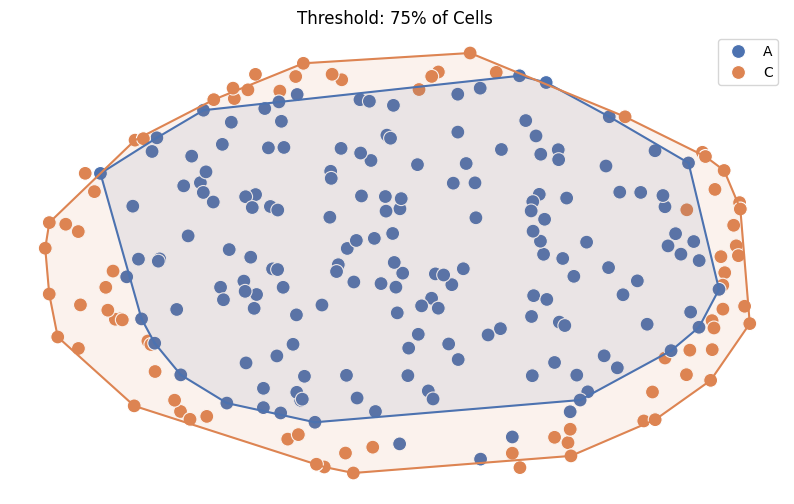

<Axes: title={'center': 'Threshold: 75% of Cells '}>

In [15]:
nodes
Edges = pd.DataFrame(edges)
Neighborhood = []

def get_type(nodes, node_idx, type = 'niche'):
    df = nodes.iloc[node_idx,:]
    return df[type]

for node in nodes.index:
    source = node
    node_source = nodes.iloc[source,:]
    targets = Edges.loc[Edges[0] == node , 1].to_list()
    sources = Edges.loc[Edges[1] == node , 0].to_list()
    if len(sources)>0:
        targets+= sources
    type_source = get_type( nodes, source, 'niche')
    associated_types = set()
    for target in targets:
        associated_types.add(get_type( nodes, target, 'niche'))
    associated_types = '_'.join(sorted(associated_types))
    if 'A' in associated_types:
        Neighborhood.append('A')
    else:
        Neighborhood.append('C')

nodes['Neighborhood'] = Neighborhood

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes['Neighborhood'], 0.75, 0.1)

In [16]:
Nodes = nodes.copy()
Nodes = Nodes.drop(['x', 'y', 'niche', 'phenotype', 'A', 'B','C','D', 'patient'],axis=1)
Nodes.sample()

,MOSNA,UTAG,CellCharter,BayesSpace,SquidPy,StLearn,imcRtools,Neighborhood
198,1,0,0,1,0,0,2,C


In [17]:
# Nodes.to_csv('../data/niche_simulations/adjacent_clusters.csv')

Comparing MOSNA and Neighborhood


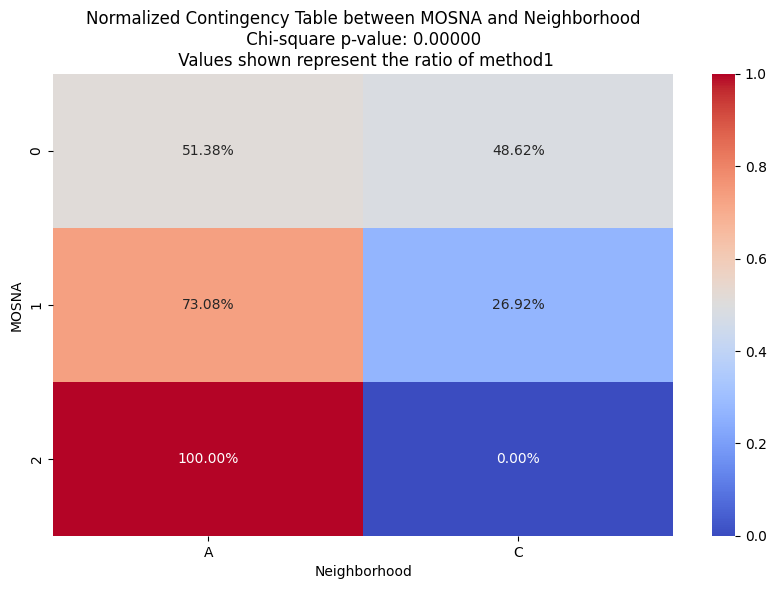

Comparing UTAG and Neighborhood


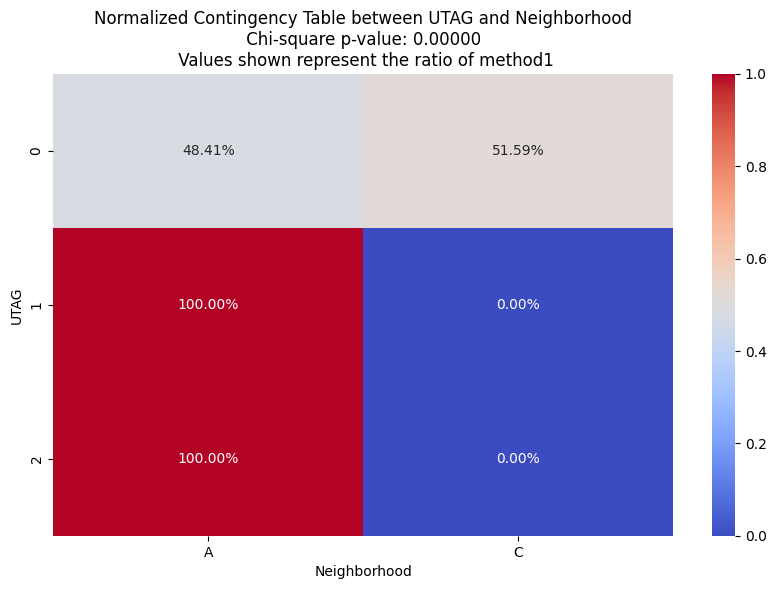

Comparing CellCharter and Neighborhood


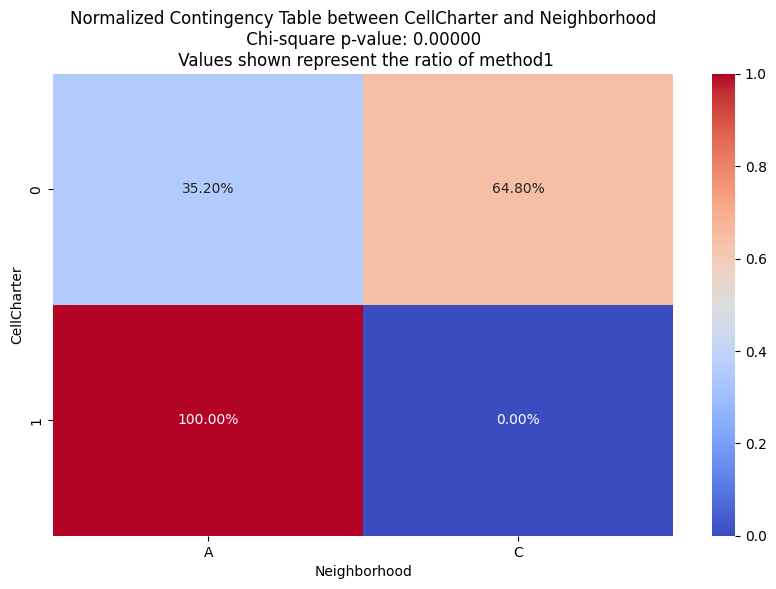

Comparing BayesSpace and Neighborhood


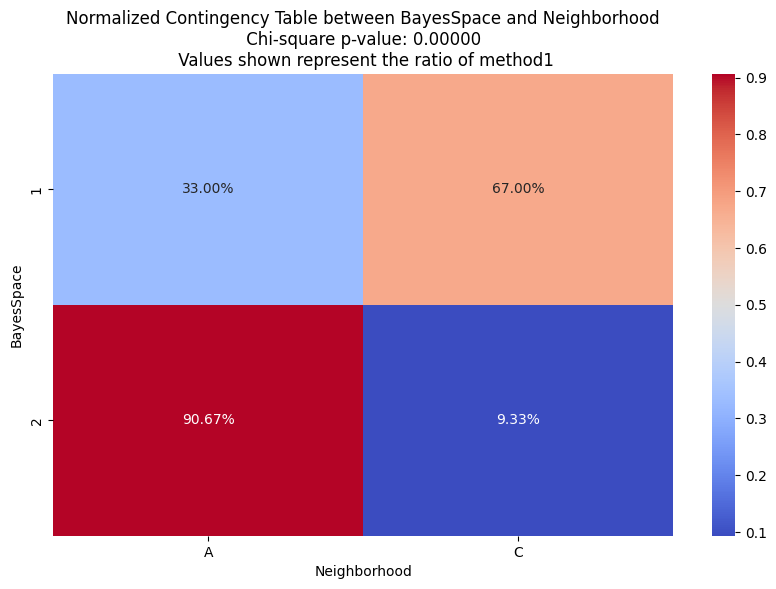

Comparing SquidPy and Neighborhood


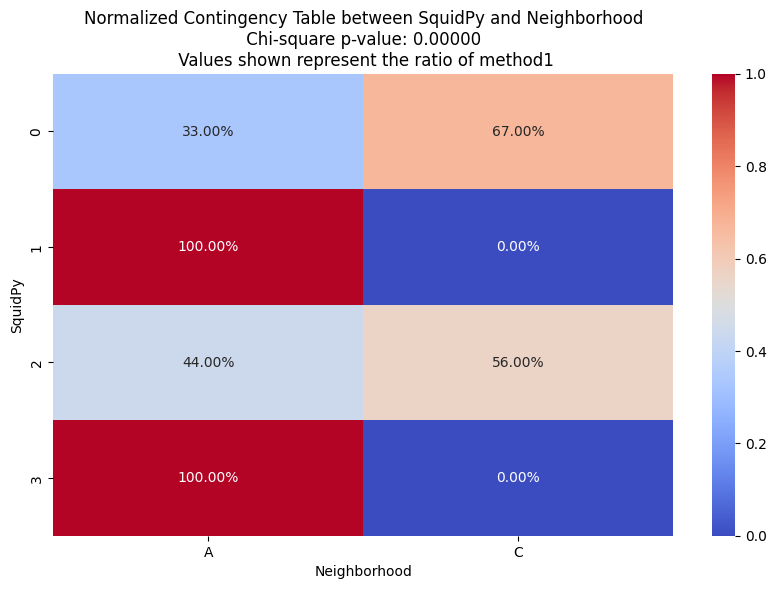

Comparing StLearn and Neighborhood


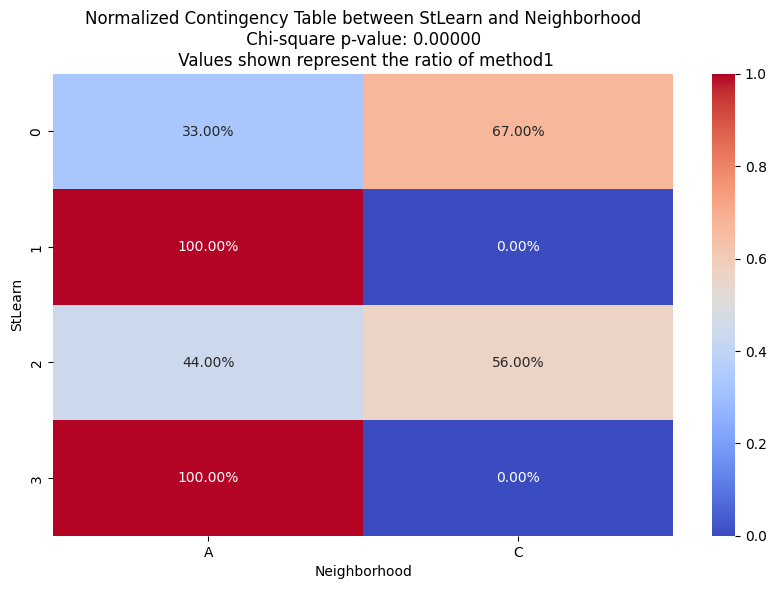

Comparing imcRtools and Neighborhood


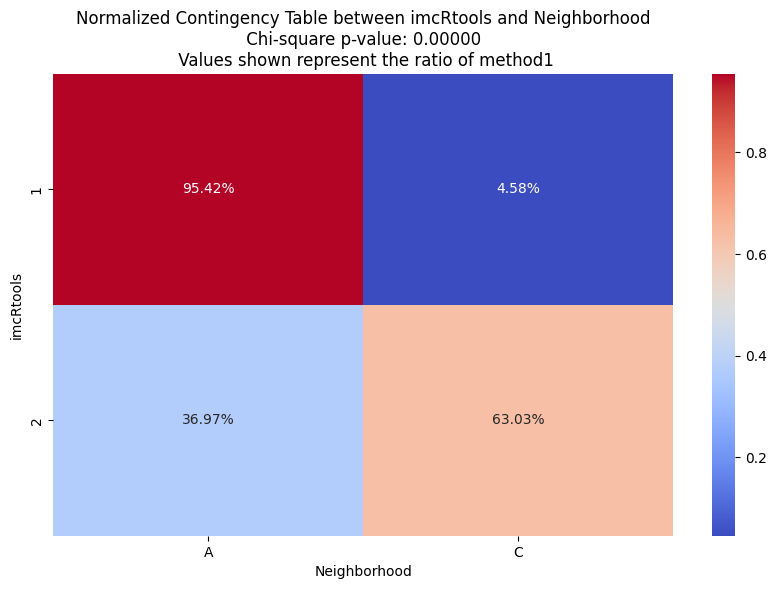

Comparing Neighborhood and Neighborhood


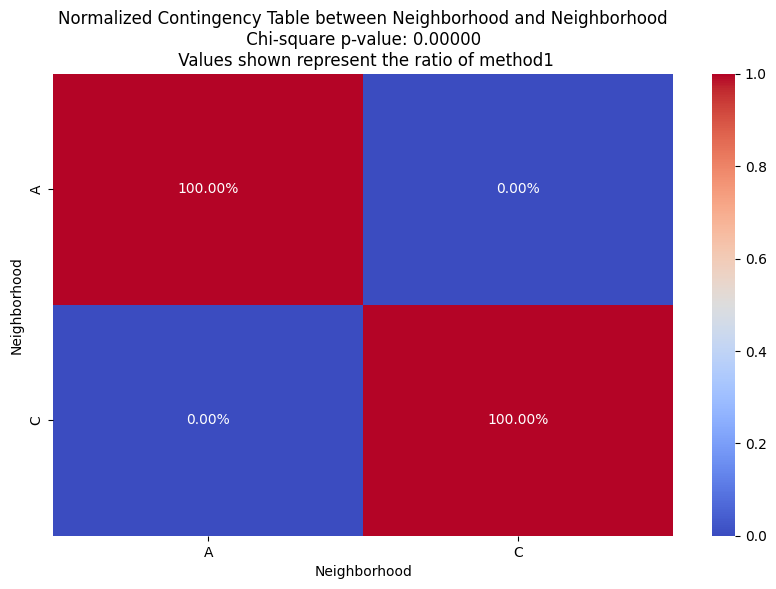

{'MOSNA': 0.7431192660550459,
 'UTAG': 0.7579617834394905,
 'CellCharter': 0.8240000000000001,
 'BayesSpace': 0.7883333333333333,
 'SquidPy': 0.835,
 'StLearn': 0.835,
 'imcRtools': 0.7922252870613895,
 'Neighborhood': 1.0}

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Create a DataFrame
df = pd.DataFrame(Nodes)


# Function to create and plot a normalized contingency table
def plot_normalized_contingency_table(df, method1, method2):
    contingency_table = pd.crosstab(df[method1], df[method2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    
    # Normalize the contingency table
    normalized_contingency_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(normalized_contingency_table, annot=True, cmap='coolwarm', fmt='.2%')
    plt.title(f'Normalized Contingency Table between {method1} and {method2}\n Chi-square p-value: {p:.5f} \n Values shown represent the ratio of method1')
    plt.show()
    
    return normalized_contingency_table

# Compare each pair of methods
methods = df.columns
mean_acc = {}
for i in range(len(methods)):
    method1 = methods[i]
    method2 = 'Neighborhood'
    print(f'Comparing {method1} and {method2}')
    contingency_table = plot_normalized_contingency_table(df, method1, method2)
    mean_acc[method1] = contingency_table.max(axis=0).mean()

mean_acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


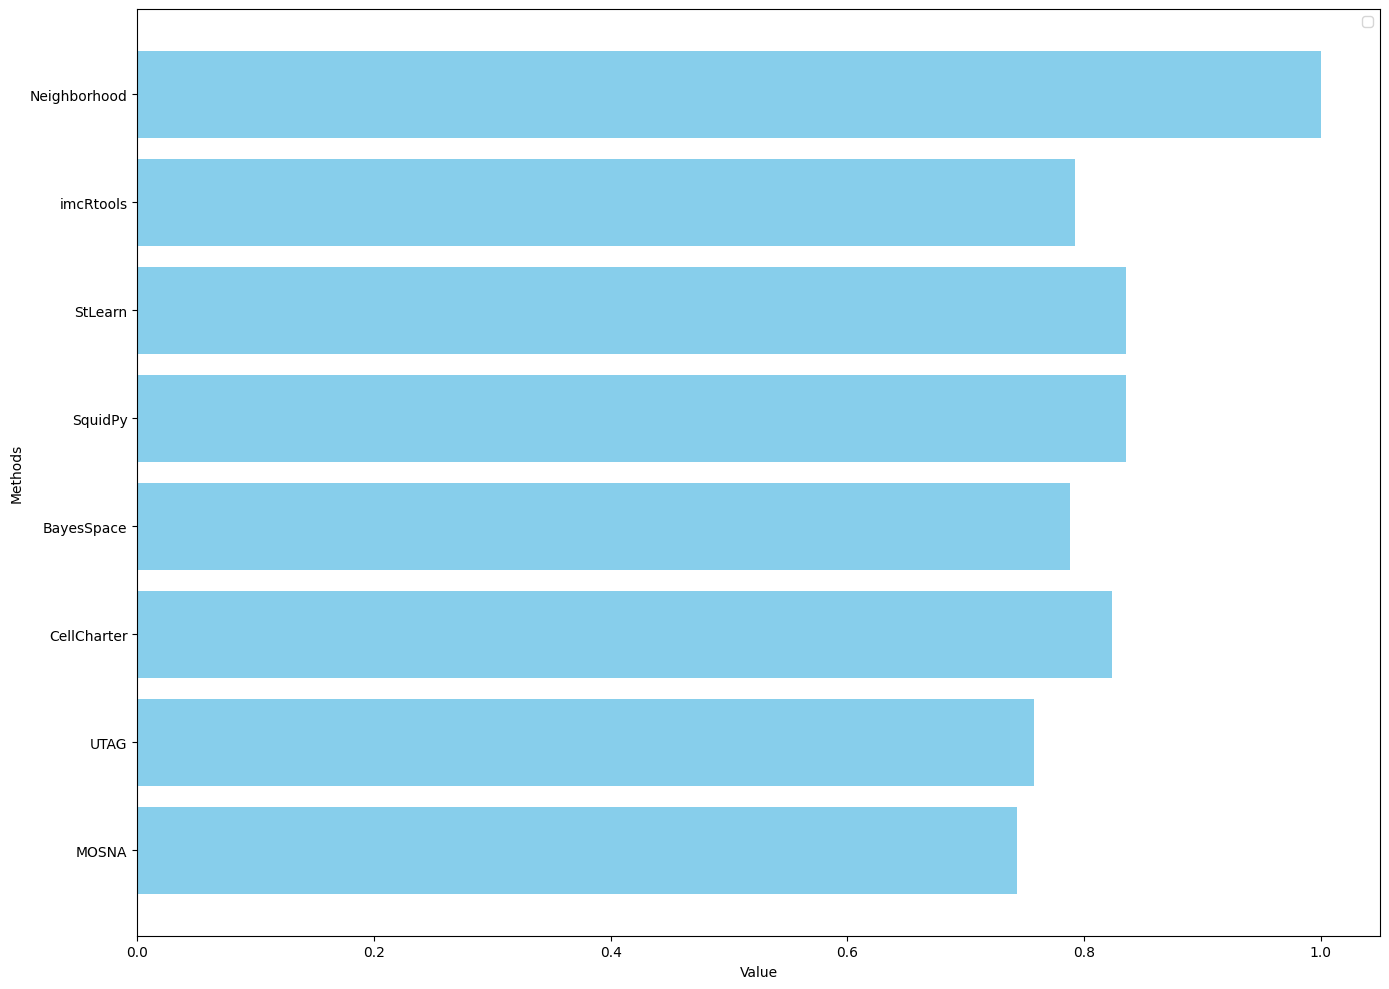

In [19]:

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(mean_acc.items()), columns=['Method', 'Value'])

# Separate the data into two categories: Dependent and Independent
df_iso = df

# Create the bidirectional bar plot
fig, ax = plt.subplots(figsize=(14, 10))

ax.barh(df_iso['Method'], df_iso['Value'], color='skyblue')

ax.set_xlabel('Value')
ax.set_ylabel('Methods')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [20]:
df_iso['model'] = type
df_iso.to_csv(f'../data/niche_simulations/nodes7{type}.csv')